## Text Clustering and Sentiment Analysis
---

With the previously pulled, cleaned and explored data (see *01_do_data_collection.py*, *02_do_data_cleaning.py*, *01_do_exploratory_data_analysis.ipynb* scripts), the following utilizes clustering and sentiment analysis to determine how depression and anxiety are differentially expressed on social media.

Overarching unsupervised questions addressed:
* What are the most common words in depression and anxiety-oriented tweet clusters? Are there any distinct differences between the two clusters?
* What topics does latent dirichlet allocation reveal according to depression and anxiety-oriented tweets?
* Does sentiment analysis show any differences in positive or negative sentiment between depression and anxiety-oriented tweets? 

Loading intial libraries...

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys 
import os
sys.path.append(os.path.abspath("/Users/emilyburns/Documents/Data_Science/projects/twitter_nlp/code/script/functions"))
from funs_do_sentiment_analysis import *
import numpy as np
import pandas as pd
import random

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emilyburns/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emilyburns/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilyburns/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading clean data...

In [2]:
clean_df = pd.read_csv('/Users/emilyburns/Documents/Data_Science/projects/twitter_nlp/data/processed_data/mi_twitter_data_clean.csv', 
                       index_col = 1)

clean_df.info()
clean_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98666 entries, 1309510316674420737 to 1309874798558736384
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date_Created     98666 non-null  object
 1   Full_Text        98666 non-null  object
 2   Entities         98666 non-null  object
 3   Count_Retweets   98666 non-null  int64 
 4   Count_Favorites  98666 non-null  int64 
 5   MI_Type          98666 non-null  int64 
 6   Clean_Text       98665 non-null  object
 7   Text_Length      98666 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 6.8+ MB


,Date_Created,Full_Text,Entities,Count_Retweets,Count_Favorites,MI_Type,Clean_Text,Text_Length
Tweet_ID,,,,,,,,
1309510316674420737,2020-09-25 15:09:23,"Whatever happens in this next wave of Covid, w...","{'hashtags': [], 'symbols': [], 'user_mentions...",357,1042,0,whatever happens in this next wave of covid we...,283
1309586933073367040,2020-09-25 20:13:50,What happened here is no less than what ISIS d...,"{'hashtags': [], 'symbols': [], 'user_mentions...",520,1471,0,what happened here is no less than what isis d...,221
1309278848568098816,2020-09-24 23:49:37,It’s not just depression it’s “unemployed duri...,"{'hashtags': [], 'symbols': [], 'user_mentions...",964,4335,0,its not just depression its unemployed during ...,202
1309907527954558983,2020-09-26 17:27:46,@sweetteatime55 @MissesDread For me it was 4 y...,"{'hashtags': [], 'symbols': [], 'user_mentions...",0,0,0,for me it was years just when i was about to g...,182
1309907495943647235,2020-09-26 17:27:38,@carolangelad @YouTube Mini Mike Bloomberg is ...,{'hashtags': [{'text': 'Trump2020LandslideVict...,0,0,0,mini mike bloomberg is paying million for felo...,234


In [3]:
clean_df['Clean_Text'] = clean_df['Clean_Text'].astype('|S')

We'll also split the full dataset into depression and anxiety specific subsets for further analysis.

In [4]:
dep_df = clean_df.loc[clean_df.MI_Type == 0].copy()
anx_df = clean_df.loc[clean_df.MI_Type == 1].copy()

---
To visualize the most common words in both subsets, we'll utilize an unsupervised learning algorithm to cluster the text. To do so, we'll first define a selection of stopwords that may otherwise  convolute significantly related words to filter out.

---

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilyburns/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
stopwords = set(stopwords.words('english'))
newStopWords = ["youre", "im", "thats", "bc", "ive"]
stopwords = stopwords.union(newStopWords)

---
Each subset's corpora must also be converted to text to be accurately evaluated.

---

In [7]:
dep_df['Clean_Text'] = dep_df['Clean_Text'].astype('|S').str.decode('utf-8')
anx_df['Clean_Text'] = anx_df['Clean_Text'].astype('|S').str.decode('utf-8')

In [8]:
dep_text = " ".join(tweet for tweet in dep_df['Clean_Text'])
anx_text = " ".join(tweet for tweet in anx_df['Clean_Text'])

In [9]:
print ("There are {} words in the combined 'depression' tweet corpus.".format(len(dep_text)))
print ("There are {} words in the combined 'anxiety' tweet corpus.".format(len(anx_text)))

There are 6493058 words in the combined 'depression' tweet corpus.
There are 6055682 words in the combined 'anxiety' tweet corpus.


---
The resulting text is then passed through the unsupervised learning algorithm to visualize the clusters in a wordcloud. 

---

In [10]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
random.seed(101)

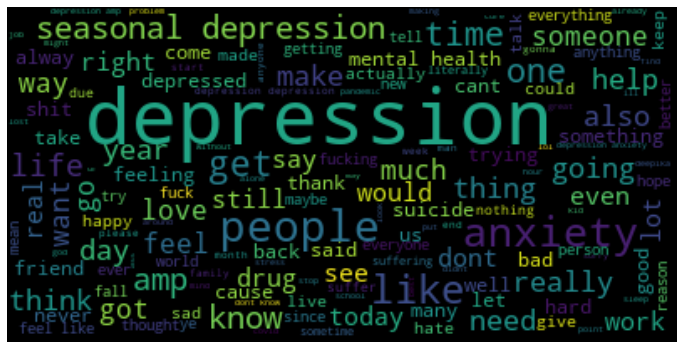

In [12]:
WordCloudViz(dep_text)

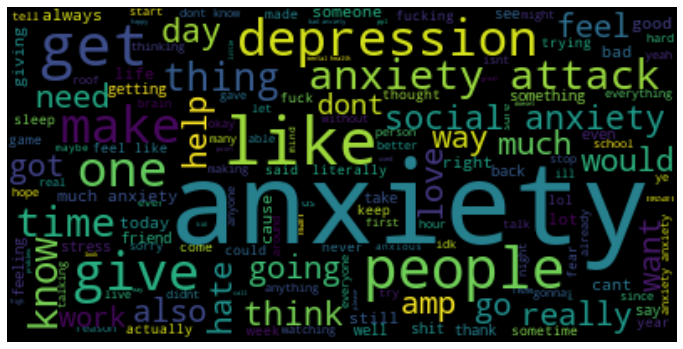

In [13]:
WordCloudViz(anx_text)

---
Each wordcloud shows the top 150 words associated with the subtopic. Each wordcloud identifies common depression and anxiety subtypes (i.e. seasonal depression, social anxiety, anxiety attack, etc.), references to current attitudes and feelings and others outside the poster (i.e. words such as 'somebody', 'friend', and 'anyone'). 

The depression wordcloud also identifies references anxiety, suicide and mental health, while anxiety identifies depression and negative descriptors such as 'bad', 'hate' and 'stress'.

---

We'll next use latent dirichlet allocation (LDA) for topic modeling according to depression and anxiety. First, we'll further split the subsets into text-only datasets. 

---

In [14]:
dep_train = dep_df['Clean_Text'].copy()
anx_train = anx_df['Clean_Text'].copy()

---
The depression and anxiety-oriented corpora are then preprocessed with lemmatization and stemming methods in order to reduce inflectional and derivationally related forms of a word.

---

In [15]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [16]:
dep_corpus = preprocess_tweets(dep_df)
anx_corpus = preprocess_tweets(anx_df)

---
Finally, the resulting corpus is run through the LDA algorithm to return the top 25 topics in each depression and anxiety-specific text. 

---

In [17]:
import gensim
from gensim.corpora import Dictionary
from gensim import corpora

In [18]:
TopicModeling(dep_corpus)

[(0,
  '0.052*"depression" + 0.016*"said" + 0.012*"called" + 0.012*"social" + 0.011*"like" + 0.011*"would" + 0.011*"song" + 0.010*"didnt" + 0.009*"told" + 0.008*"medium"'),
 (1,
  '0.065*"depression" + 0.044*"mental" + 0.026*"health" + 0.024*"people" + 0.019*"illness" + 0.014*"post" + 0.010*"whats" + 0.010*"serious" + 0.007*"postpartum" + 0.007*"like"'),
 (2,
  '0.059*"depression" + 0.018*"someone" + 0.018*"always" + 0.013*"one" + 0.012*"friend" + 0.012*"family" + 0.012*"dont" + 0.011*"please" + 0.011*"know" + 0.010*"may"'),
 (3,
  '0.070*"depression" + 0.013*"got" + 0.012*"crippling" + 0.012*"trump" + 0.008*"economy" + 0.008*"deep" + 0.007*"world" + 0.007*"country" + 0.007*"pandemic" + 0.007*"economic"'),
 (4,
  '0.081*"depression" + 0.024*"year" + 0.015*"time" + 0.012*"month" + 0.009*"back" + 0.007*"day" + 0.007*"last" + 0.006*"nap" + 0.006*"school" + 0.006*"got"'),
 (5,
  '0.069*"depression" + 0.046*"cure" + 0.024*"cured" + 0.020*"hai" + 0.012*"joke" + 0.010*"funny" + 0.008*"omg" + 

In [19]:
TopicModeling(anx_corpus)

[(0,
  '0.111*"anxiety" + 0.028*"depression" + 0.025*"fuck" + 0.015*"today" + 0.014*"day" + 0.012*"lol" + 0.012*"high" + 0.007*"bitch" + 0.007*"one" + 0.007*"sleep"'),
 (1,
  '0.059*"anxiety" + 0.015*"year" + 0.012*"get" + 0.010*"depression" + 0.010*"amp" + 0.010*"life" + 0.009*"help" + 0.009*"take" + 0.008*"lot" + 0.008*"much"'),
 (2,
  '0.075*"anxiety" + 0.025*"giving" + 0.013*"please" + 0.011*"help" + 0.009*"stop" + 0.009*"amp" + 0.008*"people" + 0.008*"much" + 0.006*"yall" + 0.006*"trump"'),
 (3,
  '0.069*"anxiety" + 0.030*"dont" + 0.025*"like" + 0.019*"know" + 0.017*"get" + 0.015*"people" + 0.013*"make" + 0.013*"feel" + 0.011*"want" + 0.011*"cant"'),
 (4,
  '0.074*"anxiety" + 0.042*"like" + 0.020*"feel" + 0.012*"got" + 0.011*"get" + 0.008*"time" + 0.008*"week" + 0.007*"last" + 0.007*"would" + 0.007*"feeling"'),
 (5,
  '0.179*"anxiety" + 0.048*"give" + 0.029*"much" + 0.023*"game" + 0.018*"roof" + 0.010*"watching" + 0.009*"giving" + 0.008*"level" + 0.007*"going" + 0.007*"driving"'),

---
Finally, we'll use the VADER library to analyze the corpus sentiment. First, we load the sentiment analyzer.

---

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

---
Next, the compound polarity scores of each tweet are generated and put into a separate column in the original, clean dataframe. Each tweet will then be classified as either 'negative' or 'postive' overall sentiment.

---

In [21]:
sentiment_df = clean_df
sentiment_df['Clean_Text'] = sentiment_df['Clean_Text'].astype('|S').str.decode('utf-8')

In [22]:
sentiment_df['sid_scores'] = sentiment_df['Clean_Text'].apply(lambda tweet: sid.polarity_scores(tweet))
sentiment_df['compound_scores'] = sentiment_df['sid_scores'].apply(lambda score_dict: score_dict['compound'])
sentiment_df['sentiment'] = sentiment_df['compound_scores'].apply(lambda c: 'positive' if c >=0 else 'negative')

sentiment_df.head()

,Date_Created,Full_Text,Entities,Count_Retweets,Count_Favorites,MI_Type,Clean_Text,Text_Length,sid_scores,compound_scores,sentiment
Tweet_ID,,,,,,,,,,,
1309510316674420737,2020-09-25 15:09:23,"Whatever happens in this next wave of Covid, w...","{'hashtags': [], 'symbols': [], 'user_mentions...",357,1042,0,whatever happens in this next wave of covid we...,283,"{'neg': 0.207, 'neu': 0.793, 'pos': 0.0, 'comp...",-0.9100,negative
1309586933073367040,2020-09-25 20:13:50,What happened here is no less than what ISIS d...,"{'hashtags': [], 'symbols': [], 'user_mentions...",520,1471,0,what happened here is no less than what isis d...,221,"{'neg': 0.479, 'neu': 0.479, 'pos': 0.042, 'co...",-0.9839,negative
1309278848568098816,2020-09-24 23:49:37,It’s not just depression it’s “unemployed duri...,"{'hashtags': [], 'symbols': [], 'user_mentions...",964,4335,0,its not just depression its unemployed during ...,202,"{'neg': 0.092, 'neu': 0.67, 'pos': 0.239, 'com...",0.7112,positive
1309907527954558983,2020-09-26 17:27:46,@sweetteatime55 @MissesDread For me it was 4 y...,"{'hashtags': [], 'symbols': [], 'user_mentions...",0,0,0,for me it was years just when i was about to g...,182,"{'neg': 0.161, 'neu': 0.839, 'pos': 0.0, 'comp...",-0.7964,negative
1309907495943647235,2020-09-26 17:27:38,@carolangelad @YouTube Mini Mike Bloomberg is ...,{'hashtags': [{'text': 'Trump2020LandslideVict...,0,0,0,mini mike bloomberg is paying million for felo...,234,"{'neg': 0.203, 'neu': 0.73, 'pos': 0.068, 'com...",-0.7650,negative


---
To help get a better picture of the associated emotions of the corpus, we'll visualize the compound sentiment scores with seaborn.

---

In [23]:
import seaborn as sns
sns.set_style('white')

<Figure size 1080x576 with 0 Axes>

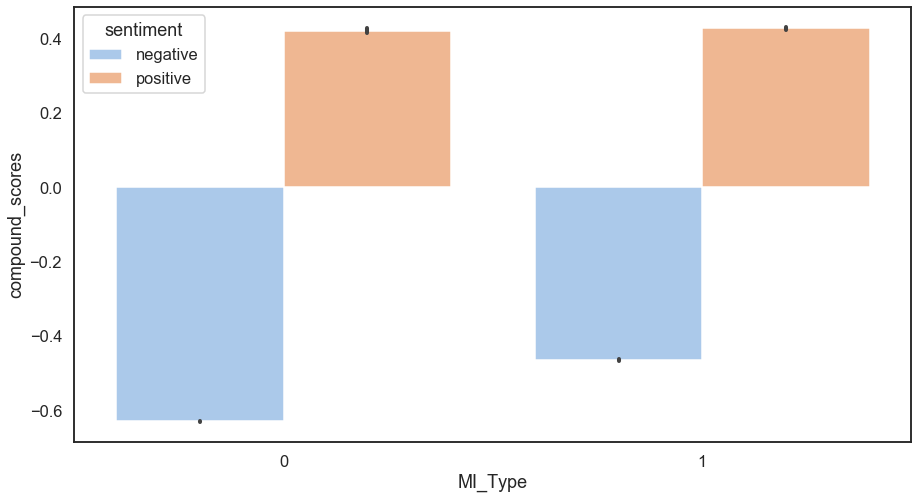

In [24]:
sns.set_context("talk")
plt.figure(figsize=(15,8))

sns.barplot(x = "MI_Type", y = "compound_scores", 
            hue = "sentiment", data = sentiment_df, palette = 'pastel')

---
From above, we can see that there are more negative-forward tweets than positive-forward tweets regarding both anxiety and depression. Depression-related tweets tend to have greater compound negative scores than anxiety-related tweets, although both have similar positive scores.

We can also plot the tweets by sentiment classification rather than compound scores.

---

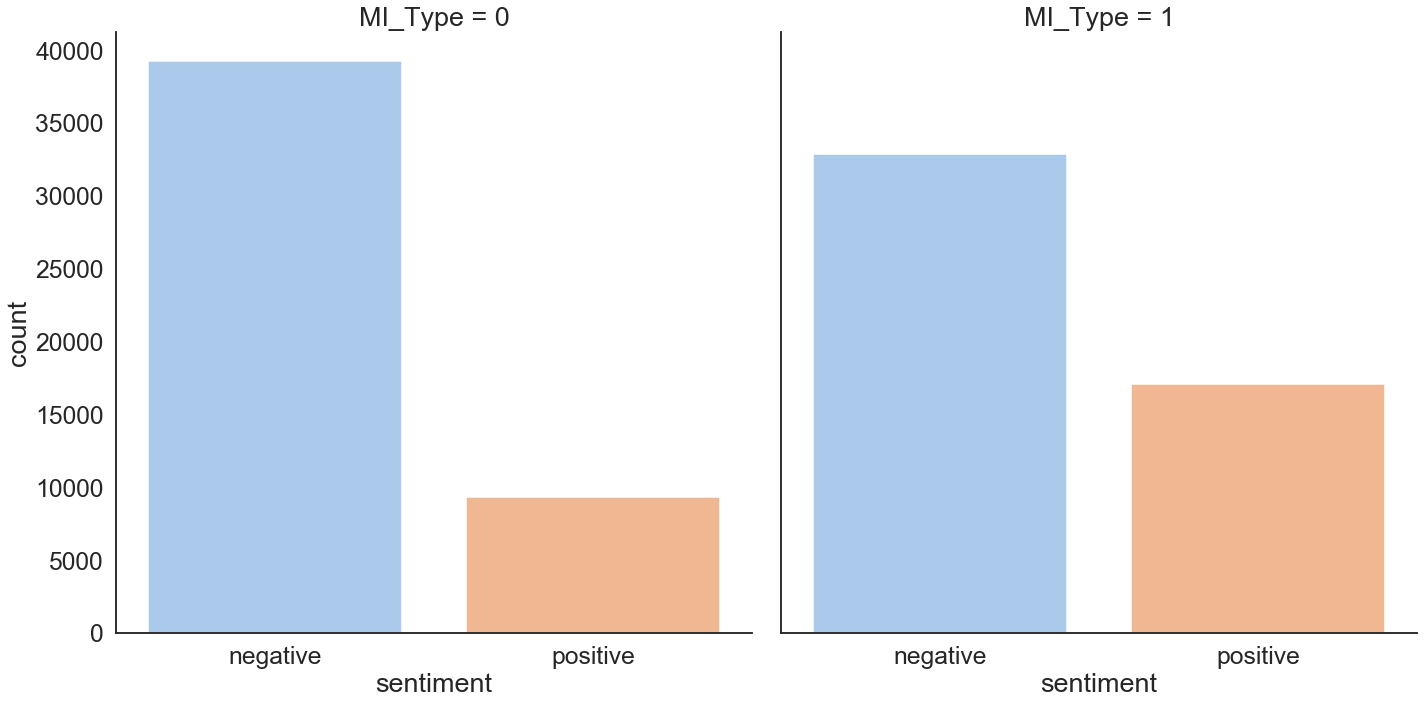

In [25]:
sns.set_context("talk", font_scale = 1.5)

sns.catplot(x = "sentiment", col="MI_Type", data = sentiment_df, kind = "count", 
            palette = "pastel", height = 10, aspect = 1)

---
Again, here we can see that there are more negative-forward tweets than positive-forward tweets regarding both anxiety and depression. Depression has more negative tweets than anxiety does, while anxiety has more positive tweets than depression.

---

As a final step, we'll save the clean dataframe with the additional sentiment analysis variables to our processed_data folder.

---

In [26]:
path = '/Users/emilyburns/Documents/Data_Science/projects/twitter_nlp/data/processed_data'
output_file = os.path.join(path,'mi_twitter_data_sentiment_analysis.csv')
sentiment_df.to_csv(output_file, index = 1)